In [2]:

import os, sys, math, gc
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import seaborn as sns
import lightgbm as lgb
import pickle as pkl
from utils.utils import merge_eval_sold_on_df, sort_df_on_d, WRMSSE, RMSSE, _down_cast, data_preprocessing, diff_lists, log_status
from utils.utils import customIter, cross_validation_on_validation_set, ensemble_submissions, ensemble_submissions_uncertainty
from utils.metrics import WSPL
from utils.configure_logger import configure_logger
configure_logger()
from logging import getLogger
logger = getLogger(__name__)

import warnings
warnings.simplefilter("ignore")

In [3]:

DATA_BASE_PATH = "../data/m5-forecasting-accuracy/"
SALES_EVALUATION = "sales_train_evaluation.csv"
SALES_VALIDATION = "sales_train_validation.csv"
CALENDAR = "calendar.csv"
SAMPLE_SUBMISSION = "sample_submission.csv"
SELL_PRICES = "sell_prices.csv"

PRECOMPUTED_BASE_PATH = "../data/uncertainty/features/"
TEST_PATH = 'test/'
precomputed_name = lambda store, eval_val: f"processed_{store}_{eval_val}.pkl"

PREDICTION_BASE_PATH = '../data/uncertainty/temp_submissions/'
SUBMISSION_BASE_PATH = '../data/uncertainty/final_submissions/'
DAYS: int = 28

SUB_D_START_VAL: int = 1914
SUB_D_START_EVAL: int = 1914 + 28

# the columns are always included after feature processing
# because they are required in the training and submission format
DROP_FEATURE_COLUMNS = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'sold']

QUANTILES: int = [0.005, 0.025, 0.165, 0.25, 0.50, 0.75, 0.835, 0.975, 0.995]

AGG_LEVEL_COLUMNS = {
    "Level1": [], # no grouping, sum of all
    "Level2": ['state_id'],
    "Level3": ['store_id'],
    "Level4": ['cat_id'],
    "Level5": ['dept_id'],
    "Level6": ['state_id', 'cat_id'],
    "Level7": ['state_id', 'dept_id'],
    "Level8": ['store_id', 'cat_id'],
    "Level9": ['store_id', 'dept_id'],
    "Level10": ['item_id'],
    "Level11": ['state_id', 'item_id'],
    "Level12": ['item_id','store_id'],
}

D_CV_START_LIST: list = [1802, 1830, 1858, 1886, 1914]


### Define GridSearch functions

###

In [4]:
@log_status
def grid_search(params: dict, param_grid: dict, features, targets, n_folds: int = 1):
    """ 
    Given a grid with parameters, train lgb model for all possible combinations.
    Returns the parameter set with the best score and the dictionary with all results.
    """
    import itertools
    
    # to be sure
    features = features.reset_index(drop=True)
    targets = targets.reset_index(drop=True)

    param_combinations = list(itertools.product(*param_grid.values()))
    results = {}
    for i, param_combination in enumerate(param_combinations,1):
        
        # create dictionary with all parameters
        param_combination = {k:v for k,v in zip(param_grid.keys(), param_combination)}
        param_combination.update(params)
        
        # init dict
        results[f"combination_{i}"] = {
            'params': param_combination,
            'res': []
        }
        
        # perform n_folds
        # from sklearn.model_selection import KFold
        # kfold = KFold(n_splits=n_folds)
        # for j, (train_idx, validation_idx) in enumerate(kfold.split(features)):
        
        for j in range(n_folds):
            
            # kfold
            features_train, features_validation, targets_train, targets_validation =\
                train_test_split(features, targets, train_size = .8, shuffle=True, random_state=42)
        
            # # split data for fold
            # features_train, features_validation = features.loc[train_idx], features.loc[validation_idx]
            # targets_train, targets_validation = targets.loc[train_idx], targets.loc[validation_idx]

            # normalize
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            targets_train = scaler\
                .fit_transform(targets_train.values.reshape(-1,1))\
                .reshape(-1)
            targets_validation = scaler\
                .transform(targets_validation.values.reshape(-1,1))\
                .reshape(-1)

            # train lgb model        
            temp_dict = {}
            mod: lgb.Booster = lgb.train(param_combination, 
                train_set = lgb.Dataset(features_train, targets_train),
                valid_sets = lgb.Dataset(features_validation, targets_validation),
                evals_result = temp_dict
            )
            
            # store results
            results[f"combination_{i}"]['res']\
                .append(temp_dict["valid_0"]["quantile"][-1],
            )

        # compute average results
        results[f"combination_{i}"]['validation_score'] = \
            np.mean(results[f"combination_{i}"]['res'])
        
    # sort the results based on evaluation score
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1]["validation_score"]))
    return list(sorted_results.values())[-1], results

In [5]:
def prep_data(level):
    # define params
    agg_level = level
    sub_d_start: int = int(1886)
    exclude_columns = []
    test = False
    type_of = 'val'

    # read file
    agg_columns = AGG_LEVEL_COLUMNS[agg_level]
    if len(agg_columns) == 0:
        agg_str: str = 'Total_X'
    elif len(agg_columns) == 1:
        agg_str: str = f'{agg_columns[0]}_X'
    else:
        agg_str: str = '_'.join(agg_columns)

    try:
        features = pd.DataFrame(features)
    except Exception:
        logger.info('(re)loading features')
        features = pd.read_parquet(f'../data/uncertainty/fold_{sub_d_start}/features/' + (TEST_PATH if test else '') + f'features_{type_of}_{agg_str}.parquet')
        features = _down_cast(features)

    group_columns = agg_columns
    exclude_prefix_list = exclude_columns # unconditional, auto, momentum, seasonal

    features_gr = features.copy()
    features_gr = features_gr[[c for c in features_gr if c.split('_')[0] not in exclude_prefix_list]]

    # preparations
    train_idx = features_gr['sold'].notna() & features_gr['d'].isin([f'd_{sub_d_start - 1 - i}' for i in range(1460)])
    df_train = features_gr[train_idx]
    features_train: pd.DataFrame = df_train.drop(DROP_FEATURE_COLUMNS, axis = 1, errors = 'ignore')
    targets_train: pd.Series = df_train['sold']
    return features_train, targets_train

In [14]:
level = 'Level5'
q = .025
n_est = 50 # 200
lr = .2 #.2

params = {
    'objective': 'quantile',
    'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
    'boosting_type': 'gbdt',
    'random_state': 43,
    'verbose': -1,
    'n_jobs': 4,
    'subsample': .5,#.5
    'subsample_freq': 1,
    "num_leaves": 2**8-1,#2**8-1,
    # 'min_data_in_leaf': 15,#2**8-1,
    'feature_fraction': 0.5, #.5
    'bagging_fraction': .8,
    "learning_rate": lr,
    "n_estimators": n_est,#100
    # "max_bin": 100,
    'boost_from_average': False,
    # "tweedie_variance_power": 1.1, # Set the Tweedie variance power (1 <= p <= 2)
    
    'reg_sqrt': True,
    'alpha': q,
}

features, targets = prep_data(level)

# kfold
features_train, features_validation, targets_train, targets_validation =\
    train_test_split(features, targets, train_size = .8, shuffle=True, random_state=42)

# normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
targets_train = scaler\
    .fit_transform(targets_train.values.reshape(-1,1))\
    .reshape(-1)
targets_validation = scaler\
    .transform(targets_validation.values.reshape(-1,1))\
    .reshape(-1)

# train lgb model        
temp_dict = {}
mod: lgb.Booster = lgb.train(params, 
    train_set = lgb.Dataset(features_train, targets_train),
    valid_sets = lgb.Dataset(features_validation, targets_validation),
    evals_result = temp_dict
)

# plt.hist(mod.predict(features_validation) - targets_validation, bins=200)
# plt.show()
# n = 100
# # plt.plot(mod.predict(features_validation)[:n])
# plt.plot(targets_validation[:n])
# plt.show()

# plt.hist(targets)
# plt.show()

2023-08-25 00:37:09 - __main__ - INFO - (re)loading features


[1]	valid_0's quantile: 0.334695
[2]	valid_0's quantile: 0.288673
[3]	valid_0's quantile: 0.233685
[4]	valid_0's quantile: 0.184378
[5]	valid_0's quantile: 0.141185
[6]	valid_0's quantile: 0.10894
[7]	valid_0's quantile: 0.0816775
[8]	valid_0's quantile: 0.0623964
[9]	valid_0's quantile: 0.0495827
[10]	valid_0's quantile: 0.0398965
[11]	valid_0's quantile: 0.0325973
[12]	valid_0's quantile: 0.0272312
[13]	valid_0's quantile: 0.0233459
[14]	valid_0's quantile: 0.0203376
[15]	valid_0's quantile: 0.018047
[16]	valid_0's quantile: 0.0163224
[17]	valid_0's quantile: 0.0151156
[18]	valid_0's quantile: 0.0143413
[19]	valid_0's quantile: 0.013736
[20]	valid_0's quantile: 0.0131315
[21]	valid_0's quantile: 0.0129173
[22]	valid_0's quantile: 0.0127275
[23]	valid_0's quantile: 0.0127265
[24]	valid_0's quantile: 0.0126043
[25]	valid_0's quantile: 0.0125135
[26]	valid_0's quantile: 0.0124953
[27]	valid_0's quantile: 0.0124319
[28]	valid_0's quantile: 0.0124024
[29]	valid_0's quantile: 0.0124132
[30

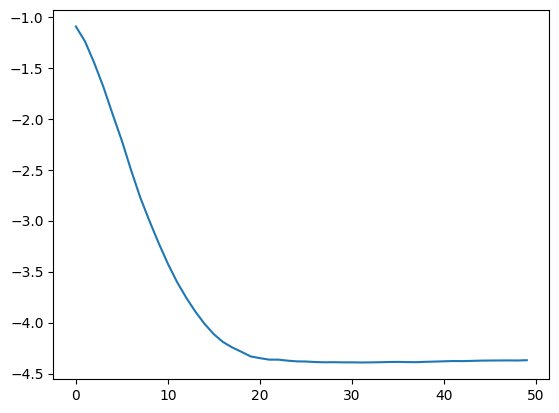

In [15]:
plt.plot(np.log(temp_dict["valid_0"]["quantile"]))
plt.show()

In [11]:
features.columns

Index(['auto_sold_7', 'auto_sold_14', 'auto_sold_2', 'auto_sold_1',
       'auto_sold_21', 'auto_sold_ma_180', 'auto_sold_ma_60',
       'auto_sold_ma_28', 'auto_sold_ma_std_7', 'auto_sold_ma_std_60',
       'auto_sold_ma_7', 'auto_sold_ma_std_180', 'auto_sold_ma_std_28',
       'autoquantiles_sold_ma_180_0.25', 'autoquantiles_sold_ma_180_0.995',
       'autoquantiles_sold_ma_60_0.995', 'autoquantiles_sold_ma_180_0.005',
       'autoquantiles_sold_ma_30_0.025', 'autoquantiles_sold_ma_30_0.75',
       'autoquantiles_sold_ma_180_0.75', 'autoquantiles_sold_ma_30_0.995',
       'autoquantiles_sold_ma_180_0.975', 'autoquantiles_sold_ma_60_0.005',
       'autoquantiles_sold_ma_30_0.975', 'autoquantiles_sold_ma_60_0.75',
       'autoquantiles_sold_ma_180_0.165', 'autoquantiles_sold_ma_30_0.165',
       'autoquantiles_sold_ma_180_0.835', 'autoquantiles_sold_ma_180_0.025',
       'autoquantiles_sold_ma_180_0.5', 'autoquantiles_sold_ma_60_0.5',
       'autoquantiles_sold_ma_60_0.025', 'autoquant

### Quick Run for Testing (Cross Validation)

In [205]:
# params_grid_train = {
#     "num_leaves": 2**8-1,#2**8-1,
#     # 'min_data_in_leaf': 15,#2**8-1,
#     'feature_fraction': 0.5, #.5
#     'bagging_fraction': .8,
#     "learning_rate": 0.2,
#     "n_estimators": 500,#100
#     # "max_bin": 100,
#     # "tweedie_variance_power": 1.1, # Set the Tweedie variance power (1 <= p <= 2)
    
#     'reg_sqrt': True,
#     'alpha': quantile,
# }

# total ~280 seconds
params = {
    'objective': 'quantile',
    'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
    'boosting_type': 'gbdt',
    'random_state': 43,
    'verbose': 1,
    'n_jobs': 4,
    'eval_at': 100,
    # 'verbose_eval': 0
    'subsample': 0.5,
    'subsample_freq': 1,
    'feature_fraction': 0.5,
    'boost_from_average': False,
    'alpha': .975
}

param_grid = {
    "num_leaves": [255], #[int(2**i) for i in [5, 6, 8]],
    'min_data_in_leaf': [255], #[int(2**i -1) for i in [5, 6, 8]]
    "learning_rate": [0.01],#[0.04, 0.02, 0.01, 0.005],
    "n_estimators": [5000], # [5000, 500, 100]
    # "tweedie_variance_power": [1.1], # Set the Tweedie variance power (1 <= p <= 2)
    # 'max_bin': [100]
}

In [1]:
features_train, targets_train = prep_data('Level5')
grid_search(params, param_grid, features_train, targets_train, 1)

NameError: name 'prep_data' is not defined

# Train + Predict submission

In [212]:
def train_level_all_quantiles(agg_level: str, type_of: str, sub_d_start: int, exclude_columns: list = [], test: bool = False):

    # type_of = 'val'
    # test = False
    # agg_level = 'Level1'
    
    agg_columns = AGG_LEVEL_COLUMNS[agg_level]
    if len(agg_columns) == 0:
        agg_str: str = 'Total_X'
    elif len(agg_columns) == 1:
        agg_str: str = f'{agg_columns[0]}_X'
    else:
        agg_str: str = '_'.join(agg_columns)

    try:
        features = pd.DataFrame(features)
    except Exception:
        logger.info('(re)loading features')
        features = pd.read_parquet(f'../data/uncertainty/fold_{sub_d_start}/features/' + (TEST_PATH if test else '') + f'features_{type_of}_{agg_str}.parquet')
        features = _down_cast(features)

    # group_columns = ['store_id', 'cat_id'] # 'store_id', 'cat_id', 'dept_id'
    # group_columns = ['store_id', 'dept_id']
    group_columns = agg_columns
    do_grid_search = False
    res: list = []

    exclude_prefix_list = exclude_columns # unconditional, auto, momentum, seasonal

    # for id, features_gr in customIter(features.groupby(group_columns)):
    #     # load grouped df
    #     features_gr: pd.DataFrame = features_gr.reset_index(drop=True)

    for i in range(1):
        features_gr = features.copy()
        
        features_gr = features_gr[[c for c in features_gr if c.split('_')[0] not in exclude_prefix_list]]
        
        # preparations
        # sub_d_start = SUB_D_START_VAL if type_of == 'val' else SUB_D_START_EVAL
        train_idx = features_gr['sold'].notna() & features_gr['d'].isin([f'd_{sub_d_start - 1 - i}' for i in range(1460)])
        pred_idx = features_gr['d'].isin([f'd_{sub_d_start + i}' for i in range(28)])
        df_train = features_gr[train_idx]
        df_pred = features_gr[pred_idx]
        features_train: pd.DataFrame = df_train.drop(DROP_FEATURE_COLUMNS, axis = 1, errors = 'ignore')
        targets_train: pd.Series = df_train['sold']
        features_predict: pd.DataFrame = df_pred.drop(DROP_FEATURE_COLUMNS, axis = 1, errors = 'ignore')
        
        if agg_level in ['Level10']:
            features_train, _, targets_train, _ = train_test_split(features_train, targets_train, train_size = .5, shuffle=True, random_state=43)        
        elif agg_level in ['Level11']:
            features_train, _, targets_train, _ = train_test_split(features_train, targets_train, train_size = .15, shuffle=True, random_state=43)
        elif agg_level in ['Level12']:
            features_train, _, targets_train, _ = train_test_split(features_train, targets_train, train_size = .05, shuffle=True, random_state=43)

        # normalise targets
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        targets_train = scaler.fit_transform(targets_train.values.reshape(-1,1))
            
        # train model for all quantiles
        for quantile in QUANTILES:
            
            # perform grid search for best parameters
            if do_grid_search == True:
                # split data to training and testing
                logger.info('divide for cross validation')
                x_train, x_test, y_train, y_test = train_test_split(features_train, targets_train, train_size=.8, shuffle=False, random_state=42)
                train_data = lgb.Dataset(x_train, y_train)
                validation_data = lgb.Dataset(x_test, y_test)
                logger.info('perform gridsearch')
                best_combination, results = grid_search(params, param_grid, train_data = train_data, validation_data = validation_data)
                del train_data; del validation_data
                params_grid_train = best_combination["params"]
            else:
                params_grid_train = {
                    'objective': 'quantile',
                    'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
                    'boosting_type': 'gbdt',
                    'random_state': 43,
                    'verbose': -1,
                    'n_jobs': 4,
                    'subsample': .5,#.5
                    'subsample_freq': 1,
                    "num_leaves": 2**8-1,#2**8-1,
                    # 'min_data_in_leaf': 15,#2**8-1,
                    'feature_fraction': 0.5, #.5
                    'bagging_fraction': .8,
                    "learning_rate": 0.2,
                    "n_estimators": 500,#100
                    # "max_bin": 100,
                    'boost_from_average': False,
                    # "tweedie_variance_power": 1.1, # Set the Tweedie variance power (1 <= p <= 2)
                    
                    'reg_sqrt': True,
                    'alpha': quantile,
                }

            # train_best_model
            mod = lgb.train(params_grid_train,
                train_set = lgb.Dataset(features_train, targets_train)
            )
            predictions = mod.predict(features_predict)
            predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,)
            
            # store predictions
            df_p = pd.DataFrame(
                {
                    'pred': predictions,
                    'd': df_pred['d'],
                }
            )
            df_p['quantile'] = quantile
            df_p['Level'] = agg_level
            df_p['type_of'] = 'validation' if type_of == 'val' else 'evaluation'
            if len(agg_columns) == 0:
                df_p['agg_column1'] = 'Total'
                df_p['agg_column2'] = 'X'
            elif len(agg_columns) == 1:
                df_p['agg_column1'] = df_pred[agg_columns[0]].values
                df_p['agg_column2'] = 'X'
            else:
                df_p['agg_column1'] = df_pred[agg_columns[0]].values
                df_p['agg_column2'] = df_pred[agg_columns[1]].values
                
            df_p = df_p[['Level', 'agg_column1', 'agg_column2', 'd', 'quantile', 'pred', 'type_of']]
            
            res.append(_down_cast(df_p))
        
    del features
        
    # storing predictions
    df_sub_val = pd.concat(res)
    group_names = '_'.join(group_columns)
    if group_names == '':
        group_names = 'Total_X'
    exclude_names = 'None' if len(exclude_prefix_list) == 0 else '_'.join(exclude_prefix_list)
    df_sub_val.to_csv(f'../data/uncertainty/fold_{str(sub_d_start)}/temp_submissions/' + f'lgb_multivariate_{type_of}_non_transposed_{group_names}_exclude_{exclude_names}.csv', index = False)
    logger.info('saved under: ' + f'../data/uncertainty/fold_{str(sub_d_start)}/temp_submissions/' + f'lgb_multivariate_{type_of}_non_transposed_{group_names}_exclude_{exclude_names}.csv')

In [213]:

EXCLUDE_COLUMNS_LIST = (
    [],
    ['seasonal'],
    ['auto'],
    ['autoquantiles'],
    ['momentum'],
    ['seasonal', 'auto', 'momentum'] # only autocorrelated quantiles
)

EXCLUDE_COLUMNS_LIST = (
    # [],
    # ['seasonal'],
    # ['momentum'],
    # ['autoquantiles'],
    # ['auto'],
    ['seasonal', 'auto', 'momentum'],
    ['auto', 'momentum']
)
for exclude_columns in EXCLUDE_COLUMNS_LIST:
    for sub_d_start in D_CV_START_LIST:
        for agg_level in AGG_LEVEL_COLUMNS:
            train_level_all_quantiles(
                agg_level, 
                sub_d_start=sub_d_start,
                type_of='val', 
                exclude_columns=exclude_columns
            )

2023-08-23 01:40:55 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8


2023-08-23 01:41:02 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_Total_X_exclude_seasonal_auto_momentum.csv
2023-08-23 01:41:02 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 01:41:27 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_state_id_exclude_seasonal_auto_momentum.csv
2023-08-23 01:41:27 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 01:42:30 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_store_id_exclude_seasonal_auto_momentum.csv
2023-08-23 01:42:30 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 01:42:53 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 01:42:53 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 01:43:45 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 01:43:45 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 01:44:42 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_state_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 01:44:42 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 01:45:55 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_state_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 01:45:55 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 01:47:14 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_store_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 01:47:14 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 01:48:44 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_store_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 01:48:44 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 01:57:23 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_item_id_exclude_seasonal_auto_momentum.csv
2023-08-23 01:57:23 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 02:08:46 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_state_id_item_id_exclude_seasonal_auto_momentum.csv
2023-08-23 02:08:46 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 02:23:59 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_item_id_store_id_exclude_seasonal_auto_momentum.csv
2023-08-23 02:23:59 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 02:24:07 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_Total_X_exclude_seasonal_auto_momentum.csv
2023-08-23 02:24:07 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 02:24:33 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_state_id_exclude_seasonal_auto_momentum.csv
2023-08-23 02:24:33 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 02:25:43 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_store_id_exclude_seasonal_auto_momentum.csv
2023-08-23 02:25:43 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 02:26:12 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 02:26:12 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 02:27:13 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 02:27:13 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 02:28:21 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_state_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 02:28:21 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 02:29:47 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_state_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 02:29:47 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 02:31:20 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_store_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 02:31:20 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 02:33:08 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_store_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 02:33:08 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 02:44:05 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_item_id_exclude_seasonal_auto_momentum.csv
2023-08-23 02:44:05 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 02:55:44 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_state_id_item_id_exclude_seasonal_auto_momentum.csv
2023-08-23 02:55:44 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 03:11:28 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_item_id_store_id_exclude_seasonal_auto_momentum.csv
2023-08-23 03:11:29 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 03:11:36 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_Total_X_exclude_seasonal_auto_momentum.csv
2023-08-23 03:11:36 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 03:12:04 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_state_id_exclude_seasonal_auto_momentum.csv
2023-08-23 03:12:04 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 03:13:20 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_store_id_exclude_seasonal_auto_momentum.csv
2023-08-23 03:13:20 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 03:13:49 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 03:13:49 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 03:14:53 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 03:14:53 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 03:16:06 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_state_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 03:16:06 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 03:17:36 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_state_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 03:17:36 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 03:19:13 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_store_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 03:19:13 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 03:21:04 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_store_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 03:21:04 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 03:32:22 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_item_id_exclude_seasonal_auto_momentum.csv
2023-08-23 03:32:22 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 03:44:23 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_state_id_item_id_exclude_seasonal_auto_momentum.csv
2023-08-23 03:44:23 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:00:21 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_item_id_store_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:00:21 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:00:28 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_Total_X_exclude_seasonal_auto_momentum.csv
2023-08-23 04:00:28 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:00:56 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_state_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:00:56 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:02:08 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_store_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:02:08 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:02:38 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:02:38 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:03:41 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:03:41 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:04:53 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_state_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:04:53 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:06:24 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_state_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:06:24 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:08:00 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_store_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:08:00 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:09:51 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_store_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:09:51 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:21:07 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_item_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:21:07 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:33:18 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_state_id_item_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:33:18 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:49:17 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_item_id_store_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:49:17 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:49:25 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_Total_X_exclude_seasonal_auto_momentum.csv
2023-08-23 04:49:25 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:49:53 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_state_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:49:53 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:51:05 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_store_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:51:05 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:51:34 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:51:34 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:52:38 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:52:38 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:53:50 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_state_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:53:50 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:55:20 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_state_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:55:20 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:56:57 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_store_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:56:57 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 04:58:49 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_store_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-08-23 04:58:49 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 05:10:09 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_item_id_exclude_seasonal_auto_momentum.csv
2023-08-23 05:10:09 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 05:22:15 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_state_id_item_id_exclude_seasonal_auto_momentum.csv
2023-08-23 05:22:15 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 05:38:21 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_item_id_store_id_exclude_seasonal_auto_momentum.csv
2023-08-23 05:38:21 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 05:38:28 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_Total_X_exclude_auto_momentum.csv
2023-08-23 05:38:28 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 05:38:56 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_state_id_exclude_auto_momentum.csv
2023-08-23 05:38:56 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 05:40:07 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_store_id_exclude_auto_momentum.csv
2023-08-23 05:40:07 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 05:40:36 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_cat_id_exclude_auto_momentum.csv
2023-08-23 05:40:36 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 05:41:40 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_dept_id_exclude_auto_momentum.csv
2023-08-23 05:41:40 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 05:42:52 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_state_id_cat_id_exclude_auto_momentum.csv
2023-08-23 05:42:52 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 05:44:24 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_state_id_dept_id_exclude_auto_momentum.csv
2023-08-23 05:44:24 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 05:46:04 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_store_id_cat_id_exclude_auto_momentum.csv
2023-08-23 05:46:04 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 05:47:54 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_store_id_dept_id_exclude_auto_momentum.csv
2023-08-23 05:47:54 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 05:59:17 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_item_id_exclude_auto_momentum.csv
2023-08-23 05:59:17 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 06:11:22 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_state_id_item_id_exclude_auto_momentum.csv
2023-08-23 06:11:22 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 06:27:26 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions/lgb_multivariate_val_non_transposed_item_id_store_id_exclude_auto_momentum.csv
2023-08-23 06:27:26 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 06:27:34 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_Total_X_exclude_auto_momentum.csv
2023-08-23 06:27:34 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 06:28:03 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_state_id_exclude_auto_momentum.csv
2023-08-23 06:28:03 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 06:29:15 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_store_id_exclude_auto_momentum.csv
2023-08-23 06:29:15 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 06:29:44 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_cat_id_exclude_auto_momentum.csv
2023-08-23 06:29:44 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 06:30:49 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_dept_id_exclude_auto_momentum.csv
2023-08-23 06:30:49 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 06:32:00 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_state_id_cat_id_exclude_auto_momentum.csv
2023-08-23 06:32:00 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 06:33:32 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_state_id_dept_id_exclude_auto_momentum.csv
2023-08-23 06:33:32 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 06:35:10 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_store_id_cat_id_exclude_auto_momentum.csv
2023-08-23 06:35:10 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 06:37:02 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_store_id_dept_id_exclude_auto_momentum.csv
2023-08-23 06:37:02 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 06:48:27 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_item_id_exclude_auto_momentum.csv
2023-08-23 06:48:27 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 07:00:33 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_state_id_item_id_exclude_auto_momentum.csv
2023-08-23 07:00:34 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 07:16:39 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions/lgb_multivariate_val_non_transposed_item_id_store_id_exclude_auto_momentum.csv
2023-08-23 07:16:39 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 07:16:46 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_Total_X_exclude_auto_momentum.csv
2023-08-23 07:16:46 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 07:17:14 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_state_id_exclude_auto_momentum.csv
2023-08-23 07:17:14 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 07:18:24 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_store_id_exclude_auto_momentum.csv
2023-08-23 07:18:24 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 07:18:52 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_cat_id_exclude_auto_momentum.csv
2023-08-23 07:18:52 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 07:19:55 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_dept_id_exclude_auto_momentum.csv
2023-08-23 07:19:55 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 07:21:05 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_state_id_cat_id_exclude_auto_momentum.csv
2023-08-23 07:21:05 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 07:22:37 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_state_id_dept_id_exclude_auto_momentum.csv
2023-08-23 07:22:37 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 07:24:15 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_store_id_cat_id_exclude_auto_momentum.csv
2023-08-23 07:24:15 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 07:26:06 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_store_id_dept_id_exclude_auto_momentum.csv
2023-08-23 07:26:06 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 07:37:29 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_item_id_exclude_auto_momentum.csv
2023-08-23 07:37:29 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 07:49:28 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_state_id_item_id_exclude_auto_momentum.csv
2023-08-23 07:49:28 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:05:40 - __main__ - INFO - saved under: ../data/uncertainty/fold_1858/temp_submissions/lgb_multivariate_val_non_transposed_item_id_store_id_exclude_auto_momentum.csv
2023-08-23 08:05:40 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:05:47 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_Total_X_exclude_auto_momentum.csv
2023-08-23 08:05:47 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:06:15 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_state_id_exclude_auto_momentum.csv
2023-08-23 08:06:15 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:07:25 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_store_id_exclude_auto_momentum.csv
2023-08-23 08:07:25 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:07:53 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_cat_id_exclude_auto_momentum.csv
2023-08-23 08:07:53 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:08:55 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_dept_id_exclude_auto_momentum.csv
2023-08-23 08:08:55 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:10:05 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_state_id_cat_id_exclude_auto_momentum.csv
2023-08-23 08:10:05 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:11:37 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_state_id_dept_id_exclude_auto_momentum.csv
2023-08-23 08:11:37 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:13:15 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_store_id_cat_id_exclude_auto_momentum.csv
2023-08-23 08:13:15 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:15:05 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_store_id_dept_id_exclude_auto_momentum.csv
2023-08-23 08:15:05 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:26:28 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_item_id_exclude_auto_momentum.csv
2023-08-23 08:26:28 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:38:28 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_state_id_item_id_exclude_auto_momentum.csv
2023-08-23 08:38:28 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:54:37 - __main__ - INFO - saved under: ../data/uncertainty/fold_1886/temp_submissions/lgb_multivariate_val_non_transposed_item_id_store_id_exclude_auto_momentum.csv
2023-08-23 08:54:37 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:54:44 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_Total_X_exclude_auto_momentum.csv
2023-08-23 08:54:44 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:55:12 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_state_id_exclude_auto_momentum.csv
2023-08-23 08:55:12 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:56:22 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_store_id_exclude_auto_momentum.csv
2023-08-23 08:56:22 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:56:50 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_cat_id_exclude_auto_momentum.csv
2023-08-23 08:56:50 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:57:52 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_dept_id_exclude_auto_momentum.csv
2023-08-23 08:57:52 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 08:59:02 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_state_id_cat_id_exclude_auto_momentum.csv
2023-08-23 08:59:02 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 09:00:32 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_state_id_dept_id_exclude_auto_momentum.csv
2023-08-23 09:00:32 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 09:02:09 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_store_id_cat_id_exclude_auto_momentum.csv
2023-08-23 09:02:09 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 09:03:59 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_store_id_dept_id_exclude_auto_momentum.csv
2023-08-23 09:03:59 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 09:15:26 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_item_id_exclude_auto_momentum.csv
2023-08-23 09:15:26 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 09:27:27 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_state_id_item_id_exclude_auto_momentum.csv
2023-08-23 09:27:27 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-08-23 09:43:47 - __main__ - INFO - saved under: ../data/uncertainty/fold_1914/temp_submissions/lgb_multivariate_val_non_transposed_item_id_store_id_exclude_auto_momentum.csv


### Load val + eval prediction files and merge to one submission file

In [15]:
# exclude_columns = '_'.join([])
# if exclude_columns == '':
#     exclude_columns = 'None'

# dfs: list = []
# for level in AGG_LEVEL_COLUMNS:
#     agg_columns = AGG_LEVEL_COLUMNS[level]
#     group_names = '_'.join(agg_columns)
#     if group_names == '':
#         group_names = 'Total_X'
        
#     i = str(1802)
#     dfs.append(
#         f'../data/uncertainty/fold_{i}/temp_submissions/' + f'lgb_multivariate_val_non_transposed_{group_names}_exclude_{exclude_columns}.csv',
#     )

# df_sub_val = ensemble_submissions_uncertainty(dfs)
# transpose = True
# if transpose == True:
#     sub_validation = df_sub_val.pivot(index='id', columns='d', values='pred').reset_index(drop=False)
#     sub_validation.columns = ["id"] + [f"F{i}" for i in range(1,DAYS+1)]

In [3]:
def read_concat_predictions(fold_name: int, exclude_columns: list = []):
    # D_CV_START_LIST
    # if fold_name not in D_CV_START_LIST:
        # raise ValueError('fold_name must be a value in D_CV_START_LIST')
        
    exclude_columns = '_'.join(exclude_columns)
    if exclude_columns == '':
        exclude_columns = 'None'

    logger.info('loading files under path:' + f'../data/uncertainty/fold_{fold_name}/temp_submissions/')

    dfs: list = []
    for level in AGG_LEVEL_COLUMNS:
        agg_columns = AGG_LEVEL_COLUMNS[level]
        group_names = '_'.join(agg_columns)
        if group_names == '':
            group_names = 'Total_X'

        dfs.append(
            f'../data/uncertainty/fold_{fold_name}/temp_submissions/' + f'lgb_multivariate_val_non_transposed_{group_names}_exclude_{exclude_columns}.csv',
        )

    return ensemble_submissions_uncertainty(dfs)

In [4]:
# df_sub_val.head(1)

In [5]:
# exclude_columns = '_'.join([])
# if exclude_columns == '':
#     exclude_columns = 'None'

# dfs: list = []
# for level in AGG_LEVEL_COLUMNS:
#     agg_columns = AGG_LEVEL_COLUMNS[level]
#     group_names = '_'.join(agg_columns)
#     if group_names == '':
#         group_names = 'Total_X'
        
#     dfs.append(
#         PREDICTION_BASE_PATH + f'lgb_multivariate_eval_non_transposed_{group_names}_exclude_{exclude_columns}.csv',
#     )

# df_sub_eval = ensemble_submissions_uncertainty(dfs)
# transpose = True
# if transpose == True:
#     sub_evaluation = df_sub_eval.pivot(index='id', columns='d', values='pred').reset_index(drop=False)
#     sub_evaluation.columns = ["id"] + [f"F{i}" for i in range(1,DAYS+1)]

In [6]:
# # sub_evaluation = pd.read_csv('../submissions/submission_baseline_evaluation.csv').drop(['Unnamed: 0'], axis=1)
# pd.concat([sub_validation, sub_evaluation]).to_csv(SUBMISSION_BASE_PATH + f'submission_lgb_ensemble{exclude_columns}.csv', index=False)
# del sub_validation; del sub_evaluation

### For Validation Prediction, we can compute WRMSSE locally

In [7]:
# load precomputed
d = pd.read_parquet('../data/uncertainty/cv_template/temp.parquet')
d_int = d['d'].str.split('_').apply(lambda x: int(x[1]))

In [8]:
def perform_cv(df: pd.DataFrame, df_sub: pd.DataFrame):
    
    # to be able to merge
    df_sub['id_merge'] = df_sub['id'].str.split('.')\
        .apply(lambda x: x[0])
    df_sub['quantile'] = df_sub['id'].str.split('.')\
        .apply(lambda x: float('.'.join([x[-2], x[-1].split('_')[0]])))
        
    # merge predictions in cv template
    p = pd.merge(
        df,
        df_sub,
        how='left',
        on=['id_merge', 'd']
    )
    # del df; del df_sub_val
    p['id_merge'] = p['id_merge'].astype(str)

    for c in ['sold', 'revenue']:
        p[c] = p[c].astype(np.float32)
    # d = d[d_int < (D_CV_START + 28)]

    return WSPL(p, [f'd_{i}' for i in range(D_CV_START, D_CV_START + 500)])

In [9]:
EXCLUDE_COLUMNS_LIST = (
    [],
    ['seasonal'],
    ['auto'],
    ['autoquantiles'],
    ['momentum'],
)

EXCLUDE_COLUMNS_LIST = (
    # ['seasonal'],
    # ['momentum'],
    # ['autoquantiles'],
    ['seasonal', 'auto', 'momentum'],
    ['auto', 'momentum'],
)

for EXCLUDE_COLUMNS in EXCLUDE_COLUMNS_LIST:
    logger.info('--------------- ' + str(EXCLUDE_COLUMNS) + ' ---------------')
    res = []
    for D_CV_START in D_CV_START_LIST:
        mean_wspl = perform_cv(_down_cast(d)[d_int < (D_CV_START + 28)], read_concat_predictions(D_CV_START, EXCLUDE_COLUMNS))
        res.append(mean_wspl)
        logger.info(str(D_CV_START) + ' - wspl: ' + str(mean_wspl))
        
    logger.info(str(D_CV_START) + ' - mean wspl: ' + str(np.mean(res)) + ' +/- ' + str(np.std(res)))
    logger.info(str(D_CV_START) + ' - raw results: ' + str(res))

2023-08-23 11:01:20 - __main__ - INFO - --------------- ['seasonal', 'auto', 'momentum'] ---------------
2023-08-23 11:01:32 - __main__ - INFO - loading files under path:../data/uncertainty/fold_1802/temp_submissions/
2023-08-23 11:02:23 - utils.metrics - INFO - reading weights file
2023-08-23 11:02:23 - utils.metrics - INFO - sorting df on d ...
2023-08-23 11:02:55 - utils.metrics - INFO - entering loop ...
2023-08-23 11:03:02 - utils.metrics - INFO - Level1 - 0.5094243163667926
2023-08-23 11:03:13 - utils.metrics - INFO - Level10 - 0.2974691040013057
2023-08-23 11:03:47 - utils.metrics - INFO - Level11 - 0.2925593341513246
2023-08-23 11:05:44 - utils.metrics - INFO - Level12 - 0.28617993644852113
2023-08-23 11:05:44 - utils.metrics - INFO - Level2 - 0.41335436599424047
2023-08-23 11:05:45 - utils.metrics - INFO - Level3 - 0.39246218255236165
2023-08-23 11:05:45 - utils.metrics - INFO - Level4 - 0.4088971129355237
2023-08-23 11:05:45 - utils.metrics - INFO - Level5 - 0.419405669054789

### Code Beneath can be used to create submission template
The submission template can be used to quickly insert your predictions.
It also contains all other (historical) sales to be able to compute the WRMSSE

In [4]:
sales_validation = pd.read_csv(DATA_BASE_PATH + SALES_VALIDATION)
sales_evaluation = pd.read_csv(DATA_BASE_PATH + SALES_EVALUATION)
calendar = pd.read_csv(DATA_BASE_PATH + CALENDAR)
sell_prices = pd.read_csv(DATA_BASE_PATH + SELL_PRICES)

df_val, submission_idx_val = data_preprocessing(sales_validation, calendar, sell_prices)
del sales_validation
df_eval, submission_idx_eval = data_preprocessing(sales_evaluation, calendar, sell_prices)
del sales_evaluation

df_val_after_release = df_val[(df_val.wm_yr_wk > df_val.release)]# & (df_val["sold"].notna())]
del df_val
df_eval_after_release = df_eval[(df_eval.wm_yr_wk > df_eval.release)]# & (df_eval["sold"].notna())]
del df_eval

In [7]:
dfs = []
df_eval_after_release['revenue'] = df_eval_after_release['sold'] * df_eval_after_release['sell_price']
for level in list(AGG_LEVEL_COLUMNS.keys()):
    c = AGG_LEVEL_COLUMNS[level]
    logger.info(level)
    agg_dict = {
        'sold': 'sum',
        'revenue': 'sum'
    }
    d1 = df_eval_after_release.groupby(c + ['d']).agg(agg_dict).reset_index(drop=False)
    d = pd.DataFrame({
        'd': d1['d'],
        'sold': d1['sold'],
        'revenue': d1['revenue']
    })
    if len(c) == 0:
        d['agg_column1'] = 'Total'
        d['agg_column2'] = 'X'
    elif len(c) == 1:
        d['agg_column1'] = d1[c[0]]
        d['agg_column2'] = 'X'
    else:
        d['agg_column1'] = d1[c[0]]
        d['agg_column2'] = d1[c[1]]
    d['id_merge'] = d['agg_column1'] + '_' + d['agg_column2']
    d['Level'] = level
    dfs.append(d[['Level', 'agg_column1', 'agg_column2', 'd', 'sold', 'revenue', 'id_merge']])
d = pd.concat(dfs)
d.head(50)
d.to_parquet('temp.parquet', index=False)

2023-08-17 17:27:39 - __main__ - INFO - Level1
2023-08-17 17:27:40 - __main__ - INFO - Level2
2023-08-17 17:27:44 - __main__ - INFO - Level3
2023-08-17 17:27:48 - __main__ - INFO - Level4
2023-08-17 17:27:51 - __main__ - INFO - Level5
2023-08-17 17:27:55 - __main__ - INFO - Level6
2023-08-17 17:28:00 - __main__ - INFO - Level7
2023-08-17 17:28:05 - __main__ - INFO - Level8
2023-08-17 17:28:10 - __main__ - INFO - Level9
2023-08-17 17:28:15 - __main__ - INFO - Level10
2023-08-17 17:28:21 - __main__ - INFO - Level11
2023-08-17 17:28:33 - __main__ - INFO - Level12


,Level,agg_column1,agg_column2,d,sold,revenue,id_merge
0,Level1,Total,X,d_10,24858.0,63029.78,Total_X
1,Level1,Total,X,d_100,23653.0,65665.71,Total_X
2,Level1,Total,X,d_1000,29241.0,82351.45,Total_X
3,Level1,Total,X,d_1001,33804.0,93975.55,Total_X
4,Level1,Total,X,d_1002,42447.0,118961.96,Total_X
5,Level1,Total,X,d_1003,40647.0,116052.48,Total_X
6,Level1,Total,X,d_1004,32039.0,89314.17,Total_X
7,Level1,Total,X,d_1005,29501.0,81688.96,Total_X
8,Level1,Total,X,d_1006,31117.0,85754.15,Total_X
9,Level1,Total,X,d_1007,27018.0,74244.86,Total_X
